In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02, exp01
import aeon.schema.foraging
from aeon.analysis.utils import visits, distancetravelled

import sys

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Get relevant time periods
# Run Time: 13 s

# Short, multianimal test sessions
#root = [Path("/ceph/aeon/aeon/data/raw/AEON3/multianimal-test")]

# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")

In [4]:
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

In [5]:
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

display(sessions)

,id,weight_enter,weight_exit,enter,exit,duration
0,BAA-1100700,26.40,28.10,2022-02-23 14:21:25.550300121,2022-02-25 16:00:50.076419830,2 days 01:39:24.526119709
1,BAA-1100700,25.50,28.45,2022-03-02 13:47:43.875840187,2022-03-02 18:14:47.459969997,0 days 04:27:03.584129810
2,BAA-1100700,24.55,24.55,2022-03-04 14:00:01.818980217,2022-03-04 14:00:49.259260178,0 days 00:00:47.440279961
3,BAA-1100700,24.55,28.27,2022-03-04 14:04:16.610499859,2022-03-04 19:24:41.778140068,0 days 05:20:25.167640209
4,BAA-1100700,26.30,26.30,2022-03-15 12:40:36.282139778,2022-03-15 15:56:55.801119804,0 days 03:16:19.518980026
5,BAA-1100700,27.60,28.80,2022-03-16 15:06:37.790820122,2022-03-16 16:44:50.910079956,0 days 01:38:13.119259834
6,BAA-1100700,25.50,28.50,2022-03-17 15:56:35.478690147,2022-03-17 17:41:48.763070107,0 days 01:45:13.284379960
7,BAA-1100700,24.30,26.80,2022-03-23 14:47:58.253819942,2022-03-24 14:08:54.449150085,0 days 23:20:56.195330143
8,BAA-1100699,26.75,29.00,2022-03-29 13:11:37.277699947,2022-04-04 09:16:51.086110115,5 days 20:05:13.808410168
9,BAA-1100701,27.00,26.70,2022-04-04 13:59:13.352029800,2022-04-04 15:19:41.652349949,0 days 01:20:28.300320149


In [10]:
for i in range(len(sessions)):
    start, end = sessions['enter'][i], sessions['exit'][i] 
    weight= api.load(root, exp02.Nest.WeightFiltered, start=start, end=end)
    print(weight)

Empty DataFrame
Columns: [value, stable]
Index: []
Empty DataFrame
Columns: [value, stable]
Index: []
Empty DataFrame
Columns: [value, stable]
Index: []
Empty DataFrame
Columns: [value, stable]
Index: []
                                    value    stable
time                                               
2022-03-15 12:40:36.670144081    8.417439  1.192189
2022-03-15 12:40:36.770175934    6.170610  1.143551
2022-03-15 12:40:36.830143929    3.849024  1.090600
2022-03-15 12:40:36.910143852    1.563415  1.036473
2022-03-15 12:40:36.990143776    0.498537  1.010970
...                                   ...       ...
2022-03-15 15:56:55.601119995 -131.399994  1.000000
2022-03-15 15:56:55.681119919 -131.399994  1.000000
2022-03-15 15:56:55.761119843 -131.399994  1.000000
2022-03-15 15:56:55.801119804 -131.399994  1.000000
2022-03-15 15:56:55.801119804 -131.399994  1.000000

[150714 rows x 2 columns]
                                    value    stable
time                                     

/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:145: UserWarning: data index for Nest_202_* contains out-of-order timestamps!
  warnings.warn(f"data index for {reader.pattern} contains out-of-order timestamps!")


                                    value    stable
time                                               
2022-04-04 15:54:07.949056149   28.078171  1.070414
2022-04-04 15:54:08.409088135   29.200245  1.127399
2022-04-04 15:54:08.489088058   30.224634  1.179454
2022-04-04 15:54:08.589056015   31.151342  1.226361
2022-04-04 15:54:08.649087906   31.980366  1.268188
...                                   ...       ...
2022-04-08 16:34:35.823647976 -134.699997  1.000000
2022-04-08 16:34:35.883615971 -134.699997  1.000000
2022-04-08 16:34:35.963615894 -134.699997  1.000000
2022-04-08 16:34:36.063648224 -134.699997  1.000000
2022-04-08 16:34:36.123616219 -134.699997  1.000000

[4453188 rows x 2 columns]
                                    value    stable
time                                               
2022-04-20 11:51:25.005663872   29.197927  1.010868
2022-04-20 11:51:25.445663929   29.153536  1.009501
2022-04-20 11:51:25.525663852   29.114147  1.008134
2022-04-20 11:51:25.605663776   29.0

/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:145: UserWarning: data index for Nest_202_* contains out-of-order timestamps!
  warnings.warn(f"data index for {reader.pattern} contains out-of-order timestamps!")


                                   value    stable
time                                              
2022-10-03 11:04:29.195263863  28.654146  0.996871
2022-10-03 11:04:29.595263958  28.670732  0.997575
2022-10-03 11:04:29.675263882  28.686586  0.998256
2022-10-03 11:04:29.755263805  28.701708  0.998913
2022-10-03 11:04:29.835264206  28.716099  0.999546
...                                  ...       ...
2022-10-10 11:00:43.716544151   4.400000  1.000000
2022-10-10 11:00:43.796544075   4.400000  1.000000
2022-10-10 11:00:43.856575966   4.400000  1.000000
2022-10-10 11:00:43.936575890   4.400000  1.000000
2022-10-10 11:00:44.016575812   4.400000  1.000000

[7735159 rows x 2 columns]


In [12]:
for i in range(5):
    print(i)
    start, end = sessions['enter'][i], sessions['exit'][i] 
    weight= api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
    print(weight['value'].to_numpy())

0
[]
1
[]
2
[]
3
[]
4
[ 25.575  25.8    25.8   ... 137.3   137.3   137.3  ]


In [7]:
weight

,value,stable
time,,


BAA-1100700
2022-02-23 14:21:25.550300121 2022-02-25 16:00:50.076419830


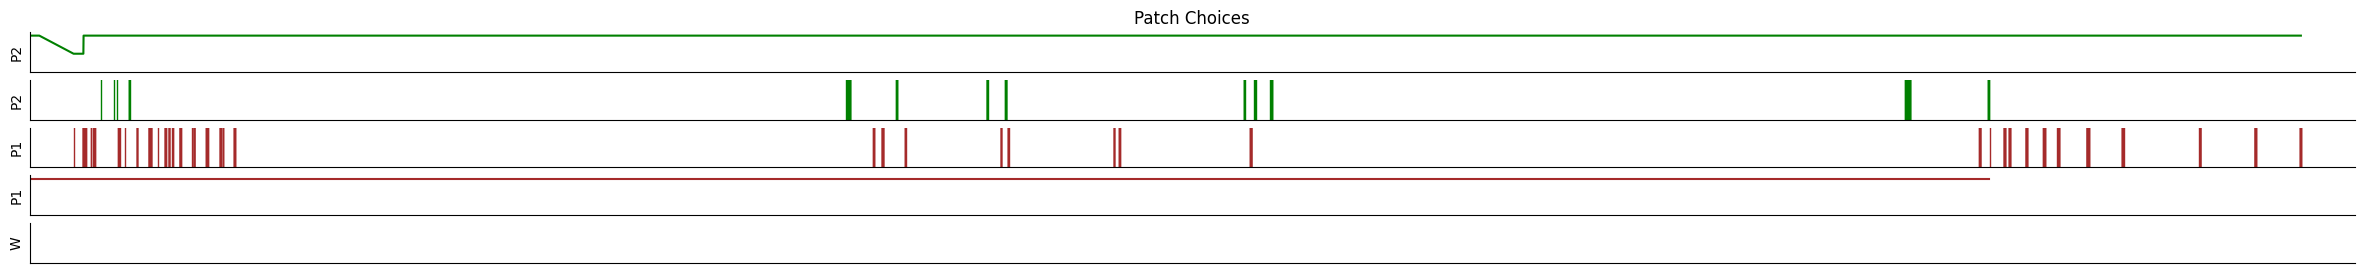

BAA-1100700
2022-03-02 13:47:43.875840187 2022-03-02 18:14:47.459969997


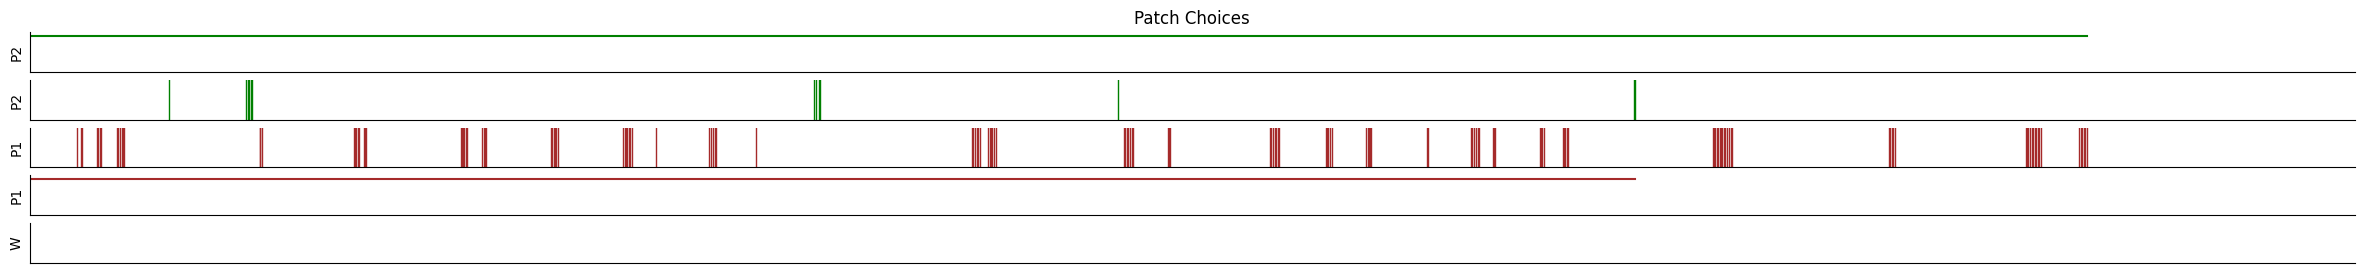

BAA-1100700
2022-03-04 14:00:01.818980217 2022-03-04 14:00:49.259260178


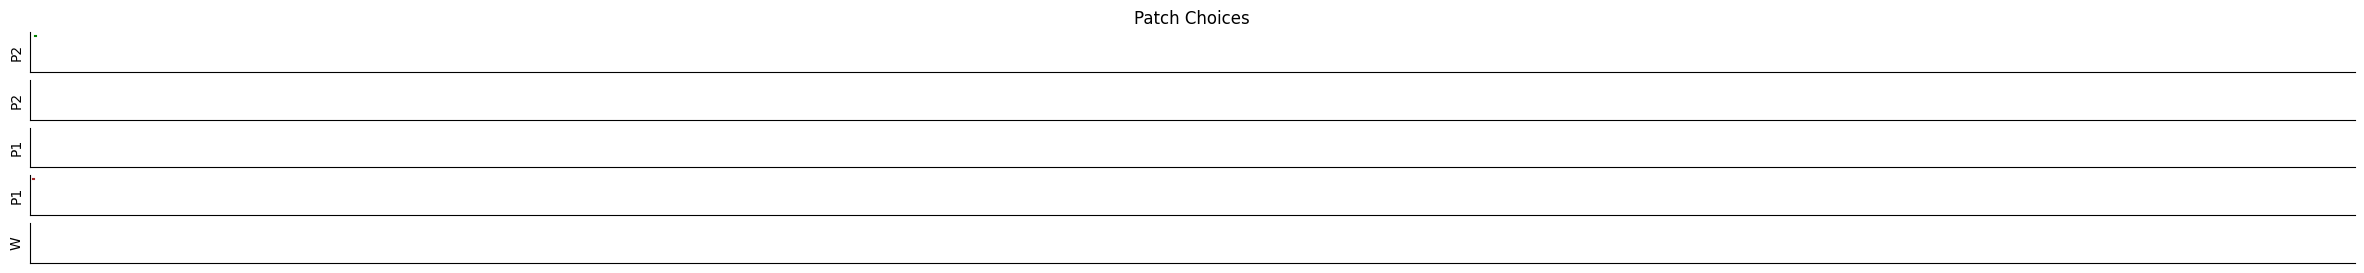

BAA-1100700
2022-03-04 14:04:16.610499859 2022-03-04 19:24:41.778140068


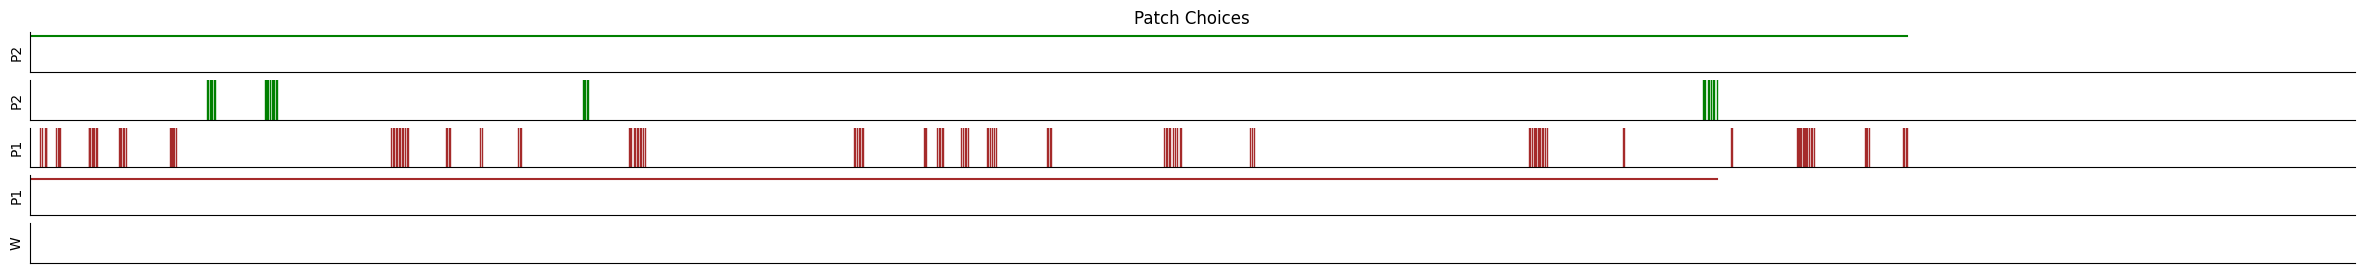

BAA-1100700
2022-03-15 12:40:36.282139778 2022-03-15 15:56:55.801119804


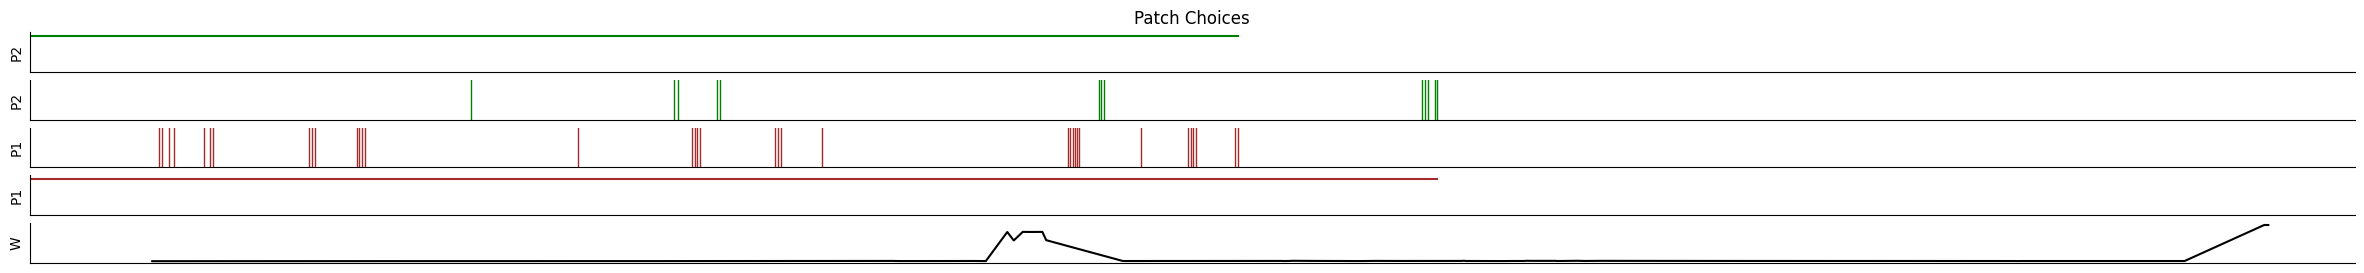

BAA-1100700
2022-03-16 15:06:37.790820122 2022-03-16 16:44:50.910079956


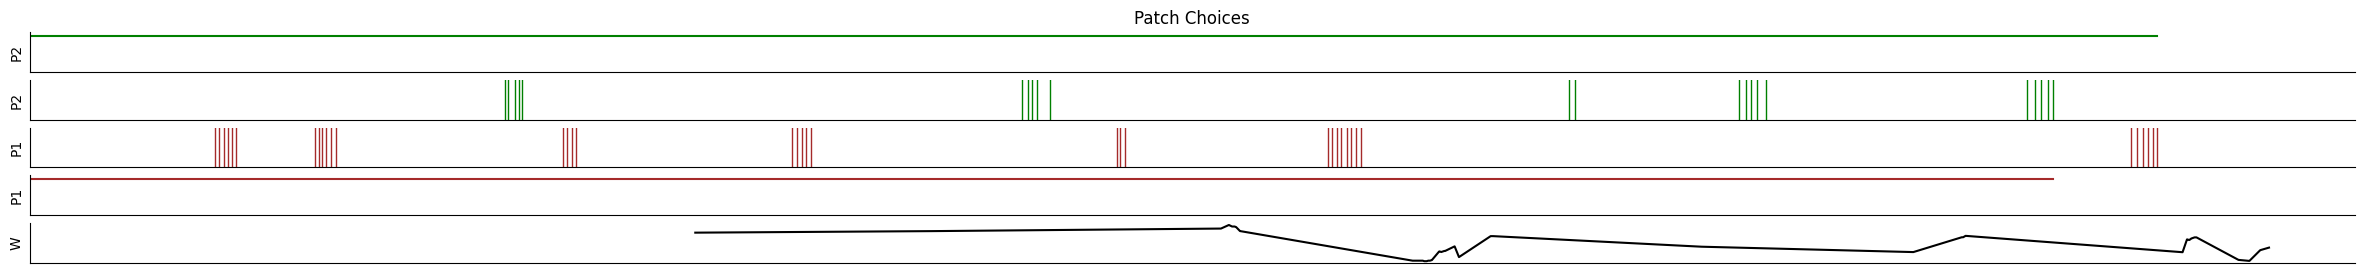

BAA-1100700
2022-03-17 15:56:35.478690147 2022-03-17 17:41:48.763070107


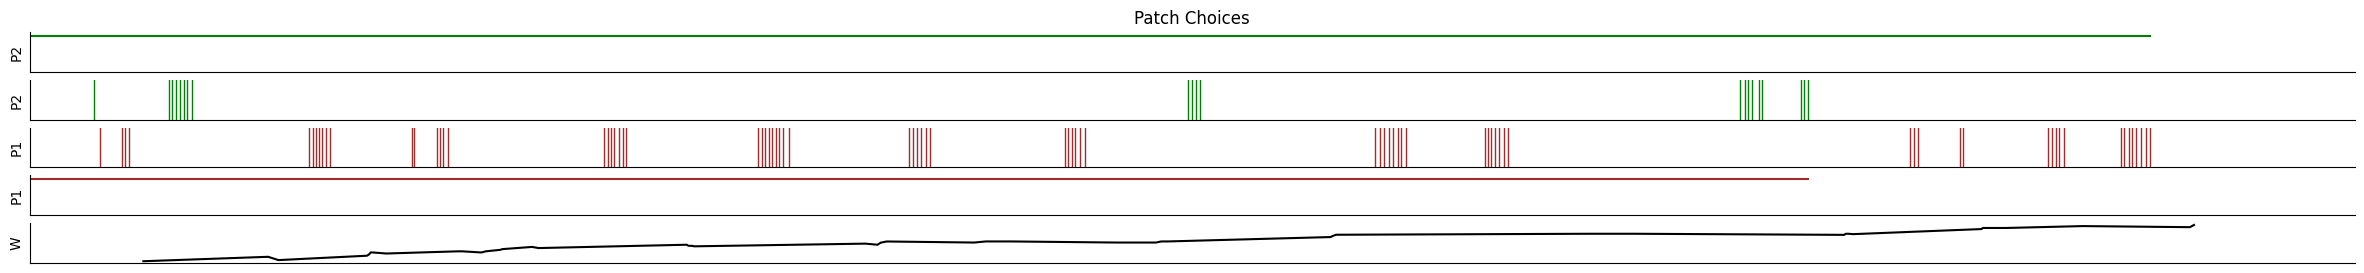

BAA-1100700
2022-03-23 14:47:58.253819942 2022-03-24 14:08:54.449150085


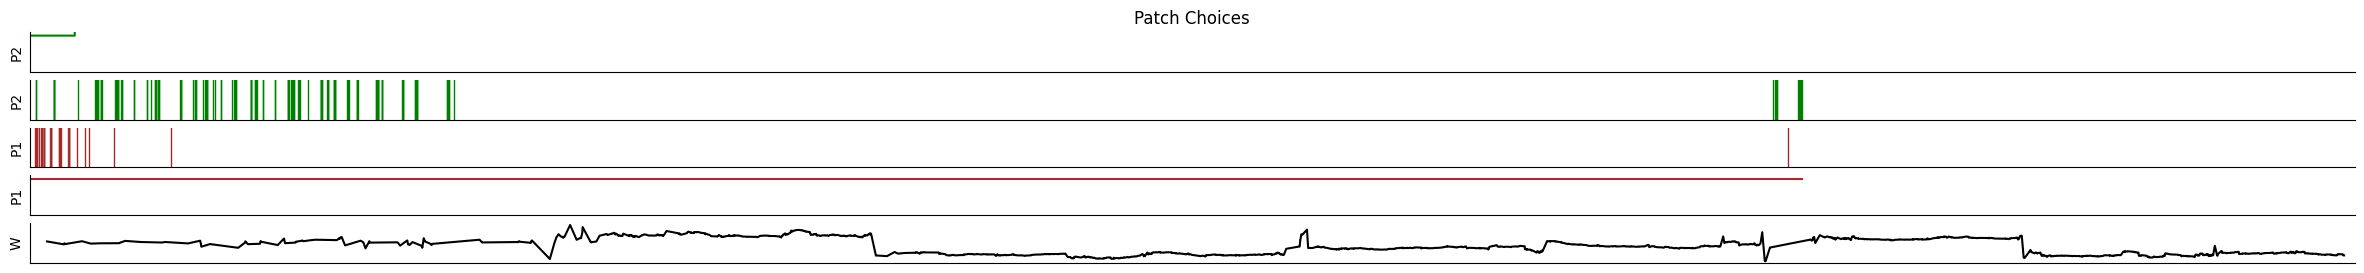

BAA-1100699
2022-03-29 13:11:37.277699947 2022-04-04 09:16:51.086110115


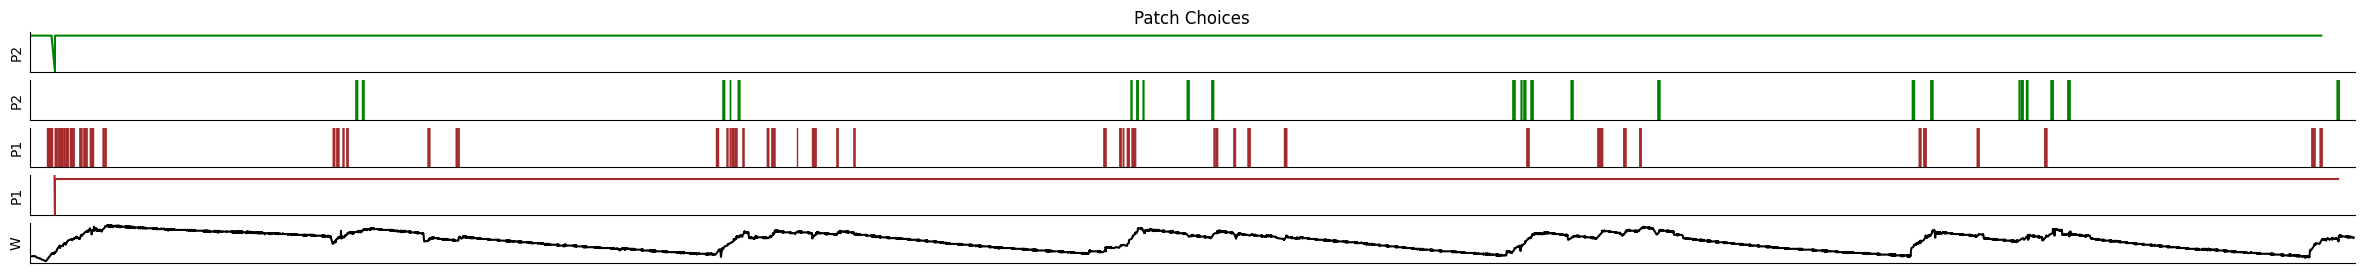

BAA-1100701
2022-04-04 13:59:13.352029800 2022-04-04 15:19:41.652349949


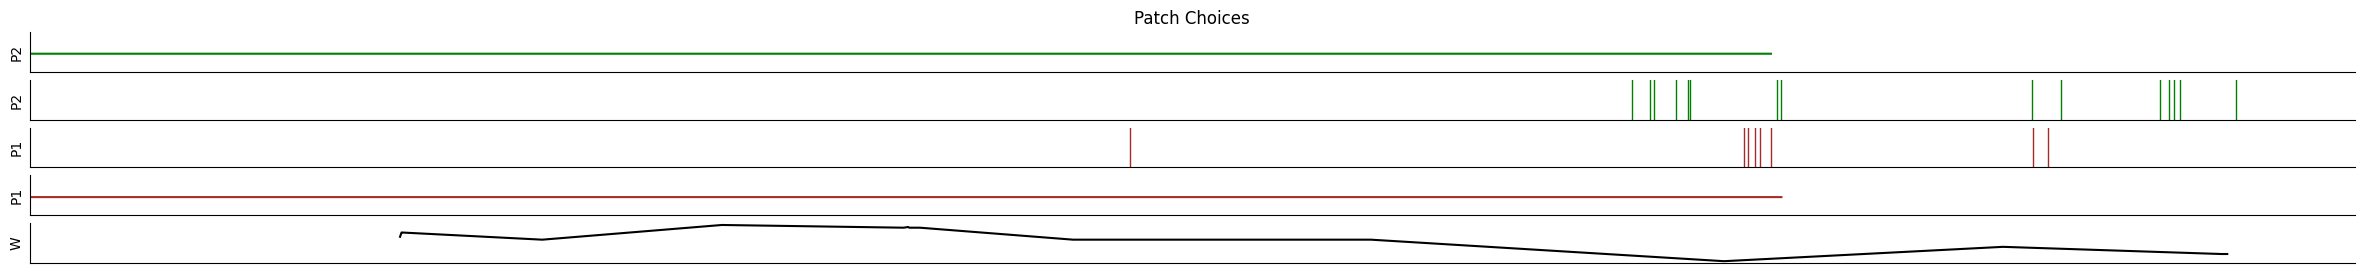

BAA-1100701
2022-04-04 15:54:07.945059776 2022-04-08 16:34:36.183650017


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:145: UserWarning: data index for Nest_204_* contains out-of-order timestamps!
  warnings.warn(f"data index for {reader.pattern} contains out-of-order timestamps!")


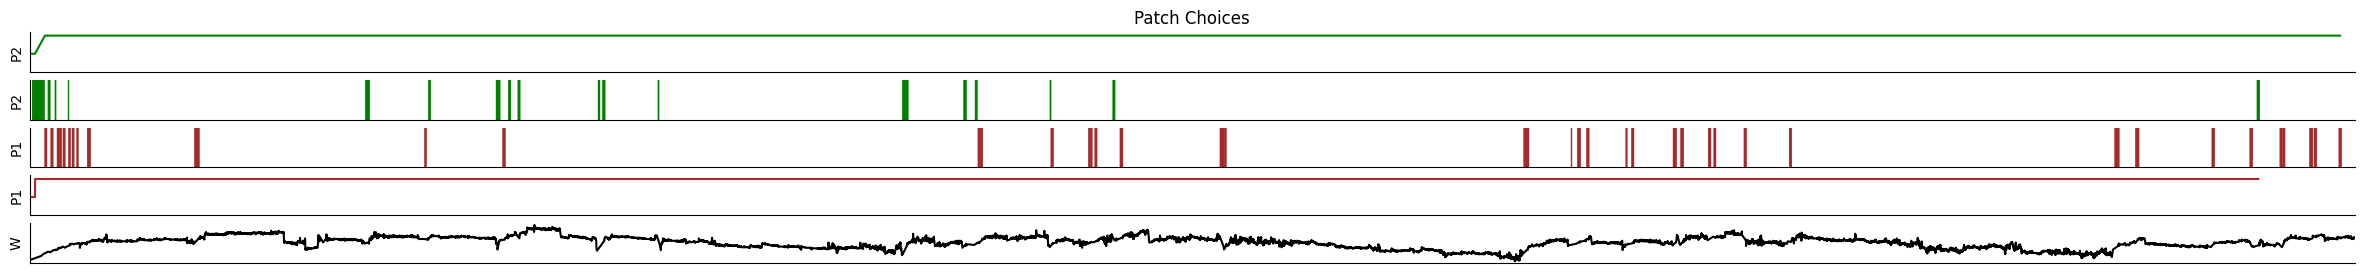

BAA-1100699
2022-04-20 11:51:24.997630119 2022-04-28 10:02:56.655809879


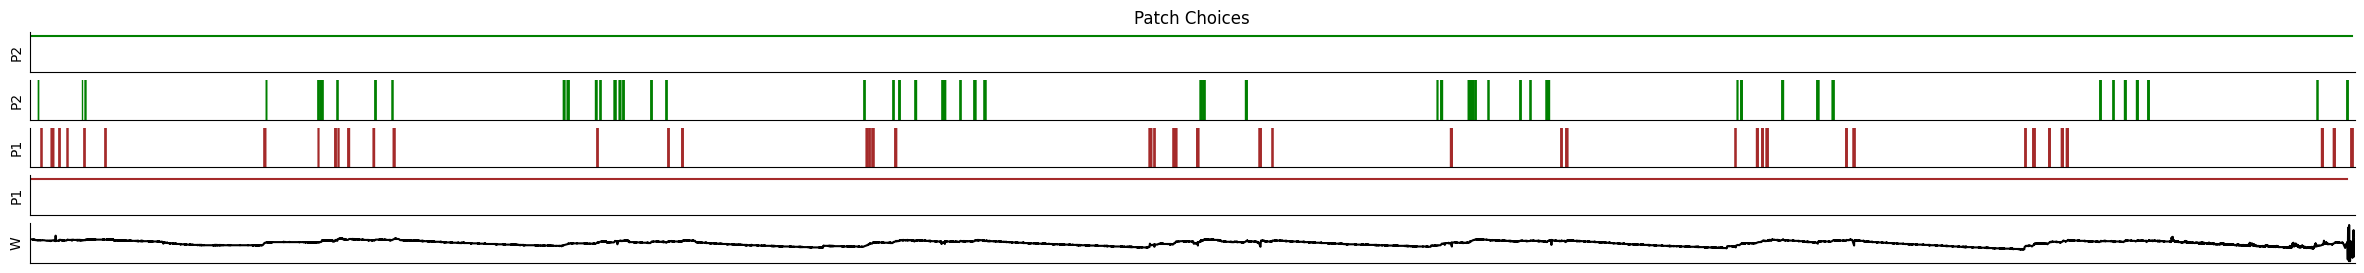

BAA-1100700
2022-04-29 09:37:08.806660175 2022-04-29 12:40:39.900259972


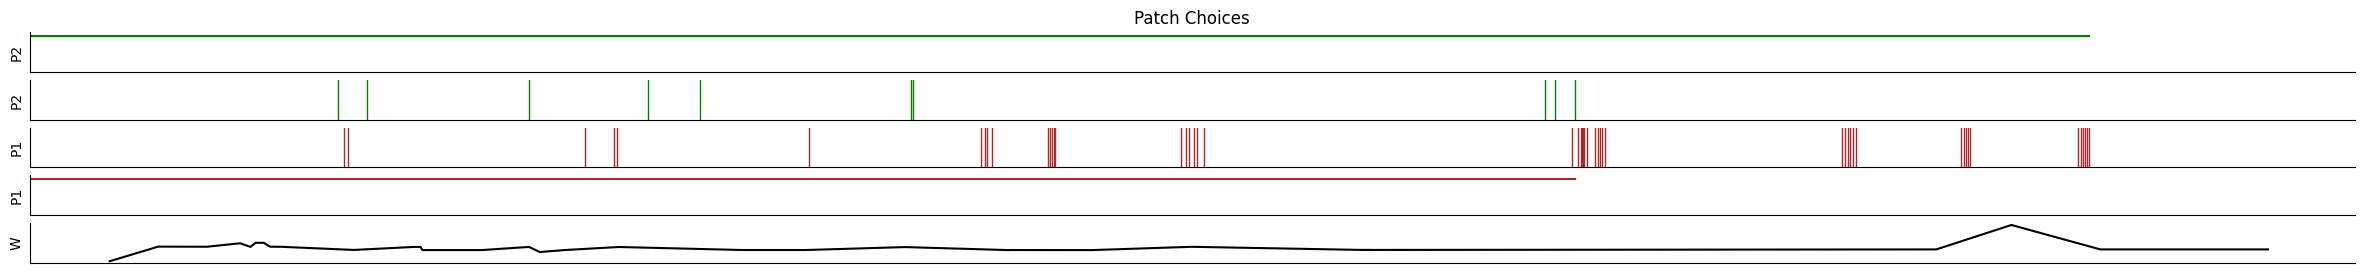

BAA-1100701
2022-04-29 09:37:50.754849911 2022-04-29 12:40:51.436289787


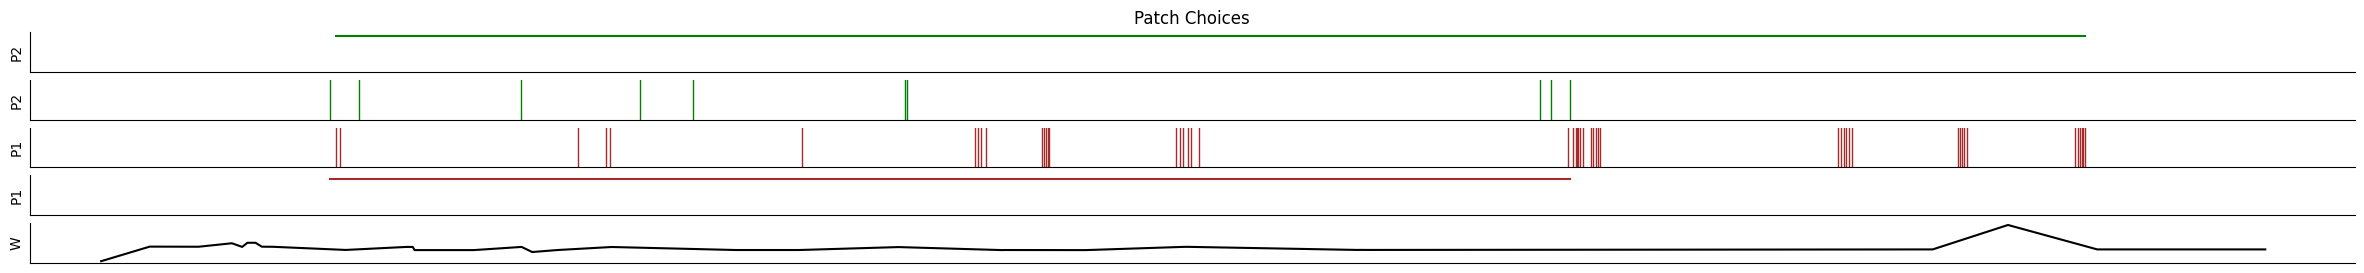

BAA-1100702
2022-05-03 11:08:12.660739899 2022-05-12 09:21:42.411650181


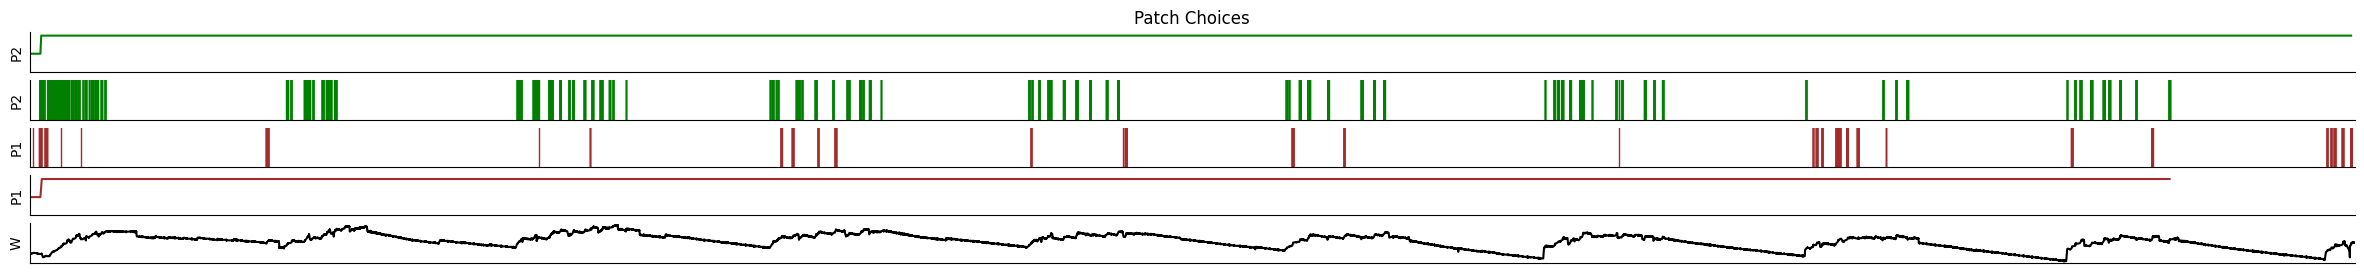

BAA-1100703
2022-05-25 08:59:51.050459862 2022-06-06 07:55:37.501309872


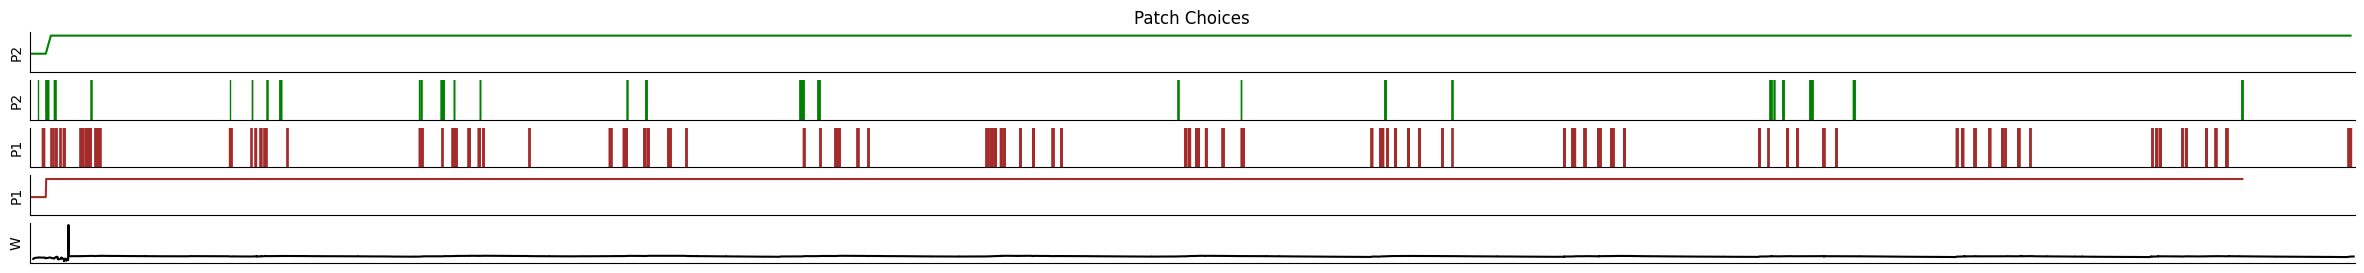

BAA-1101818
2022-06-21 10:27:42.615139961 2022-06-21 13:15:50.564740181


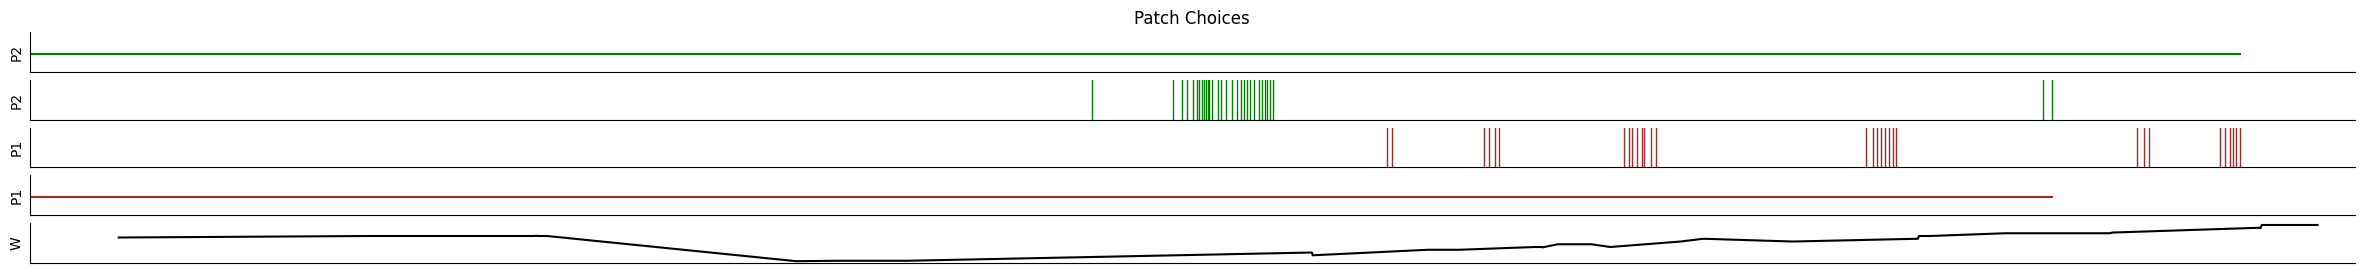

BAA-1101819
2022-06-21 13:28:10.593659878 2022-06-21 16:34:29.241280079


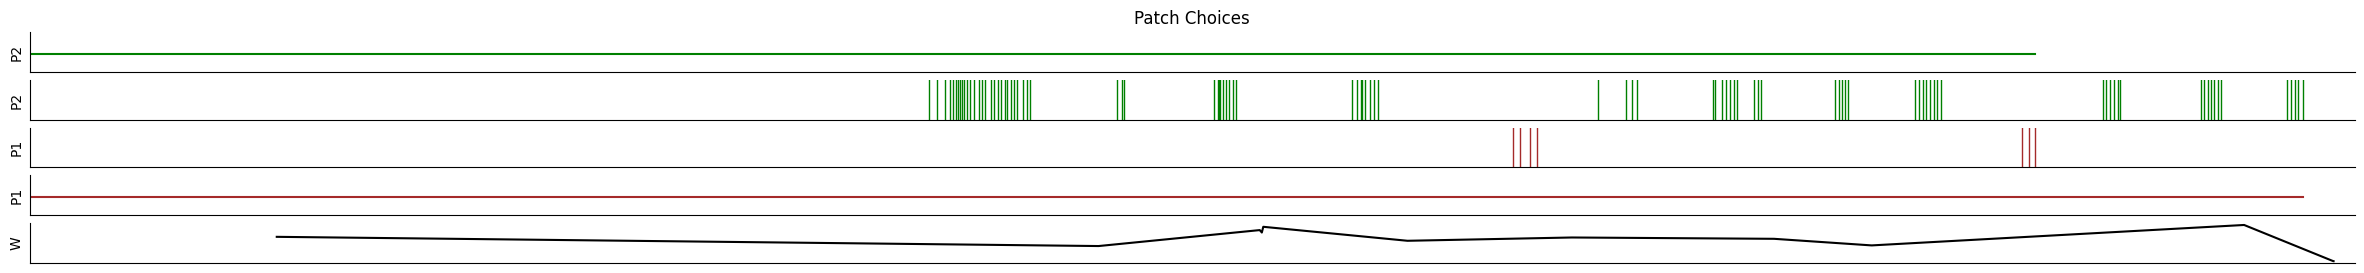

BAA-1101818
2022-06-22 07:55:41.628640175 2022-06-22 13:29:04.050240040


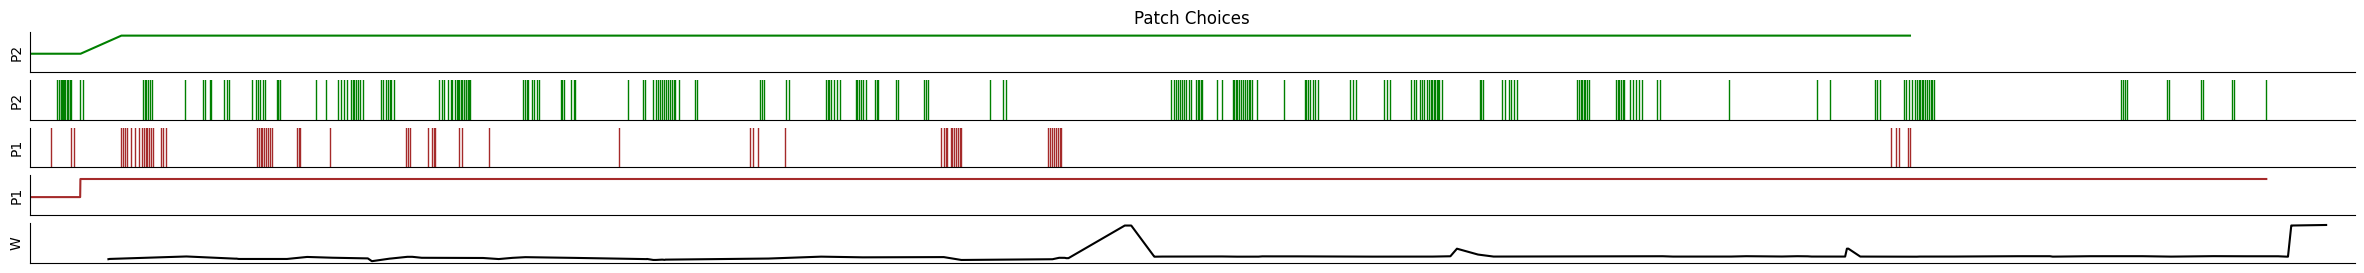

BAA-1101819
2022-06-22 07:55:57.696700096 2022-06-22 13:29:13.682270050


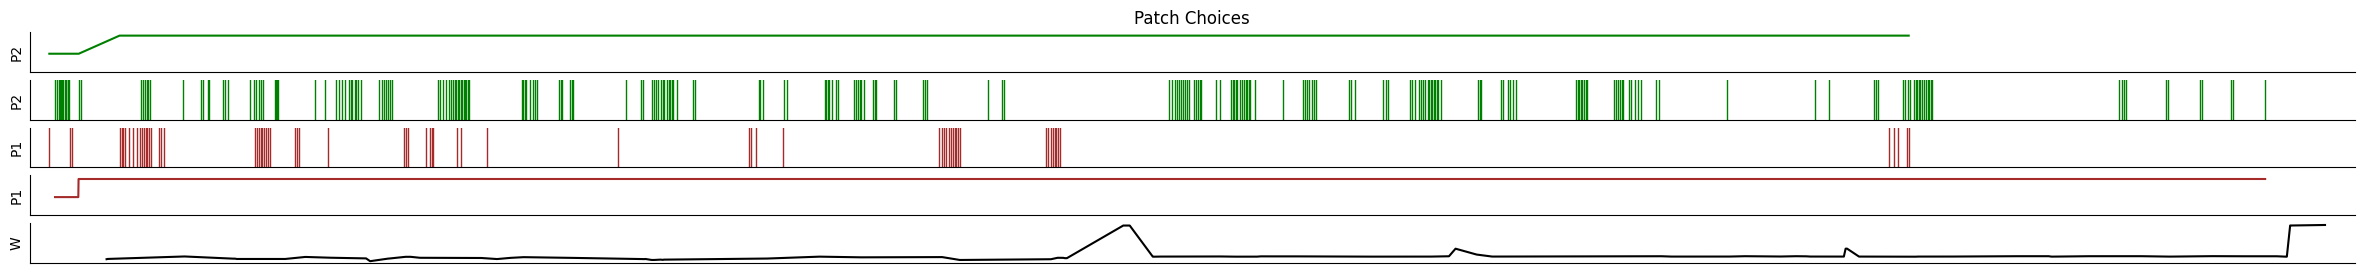

BAA-1101818
2022-06-23 08:39:04.261089801 2022-06-23 11:14:46.121759892


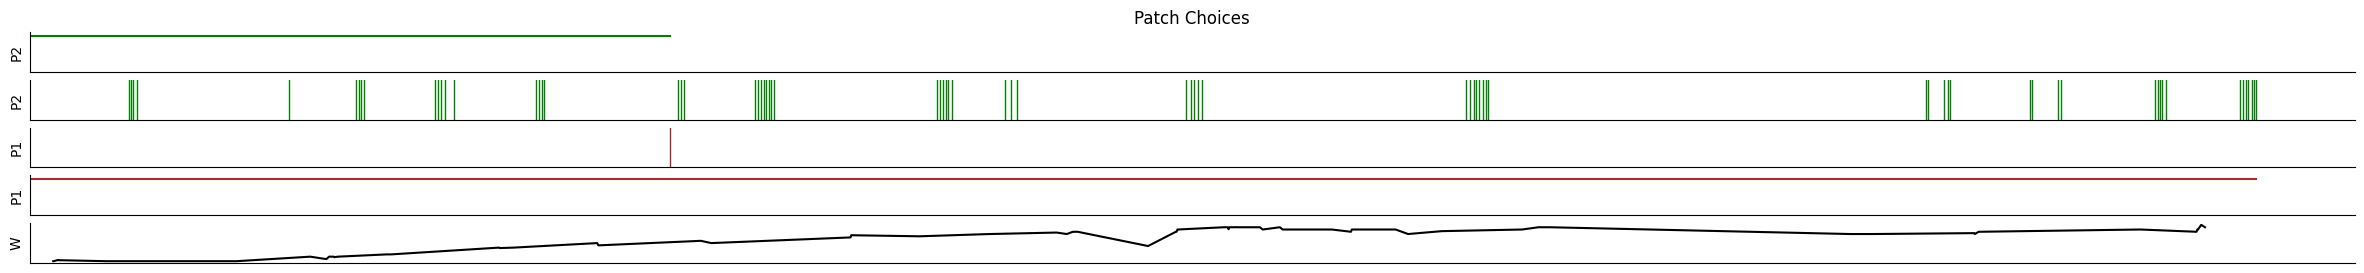

BAA-1101818
2022-06-23 11:24:11.156350136 2022-06-23 14:19:39.241819859


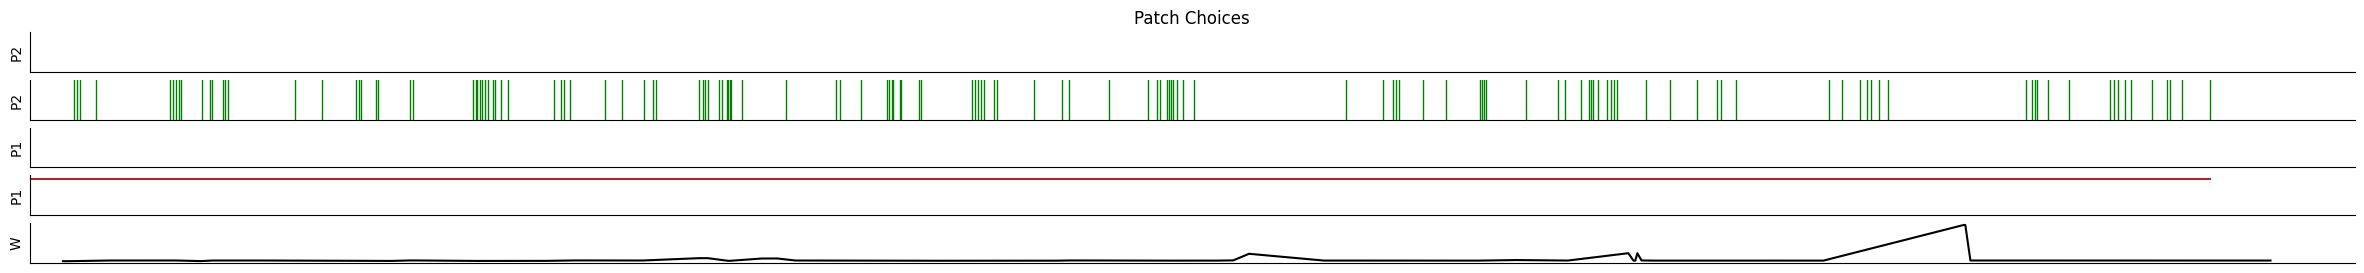

BAA-1101819
2022-06-23 11:24:23.876420021 2022-06-23 14:19:47.293859959


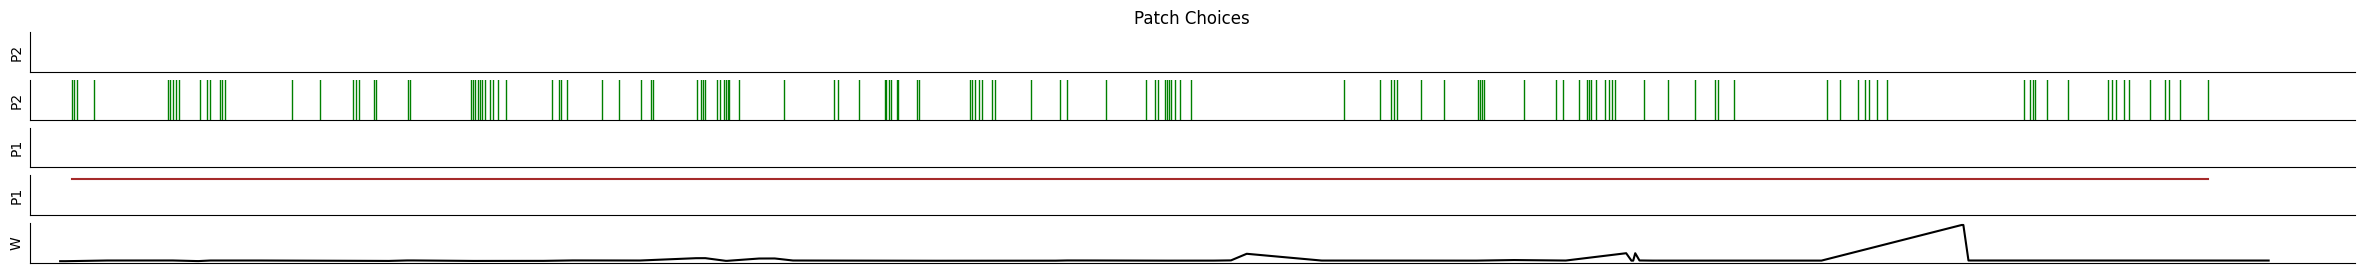

BAA-1101818
2022-06-24 09:32:37.183360100 2022-06-24 12:29:54.365859985


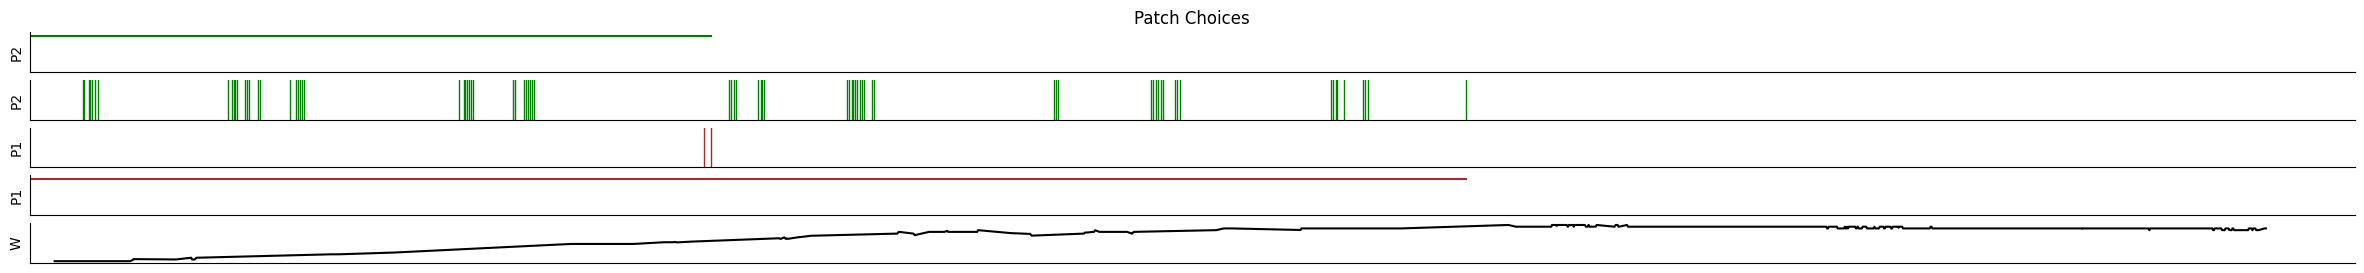

BAA-1101823
2022-07-14 12:53:15.740799904 2022-07-14 16:35:05.846270084


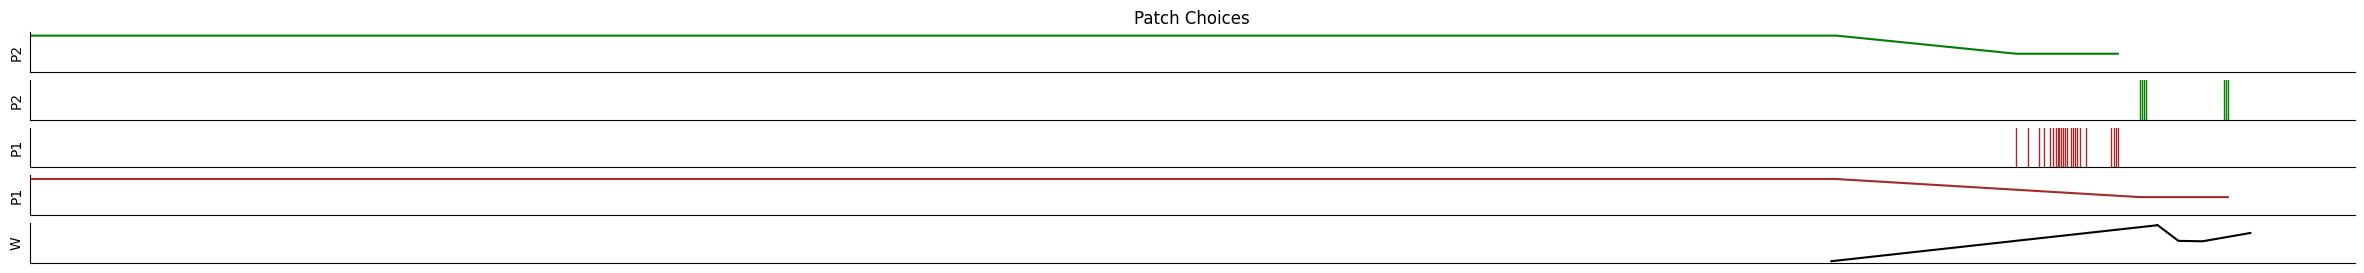

BAA-1101821
2022-07-15 13:14:40.239679813 2022-07-15 15:47:44.568860054


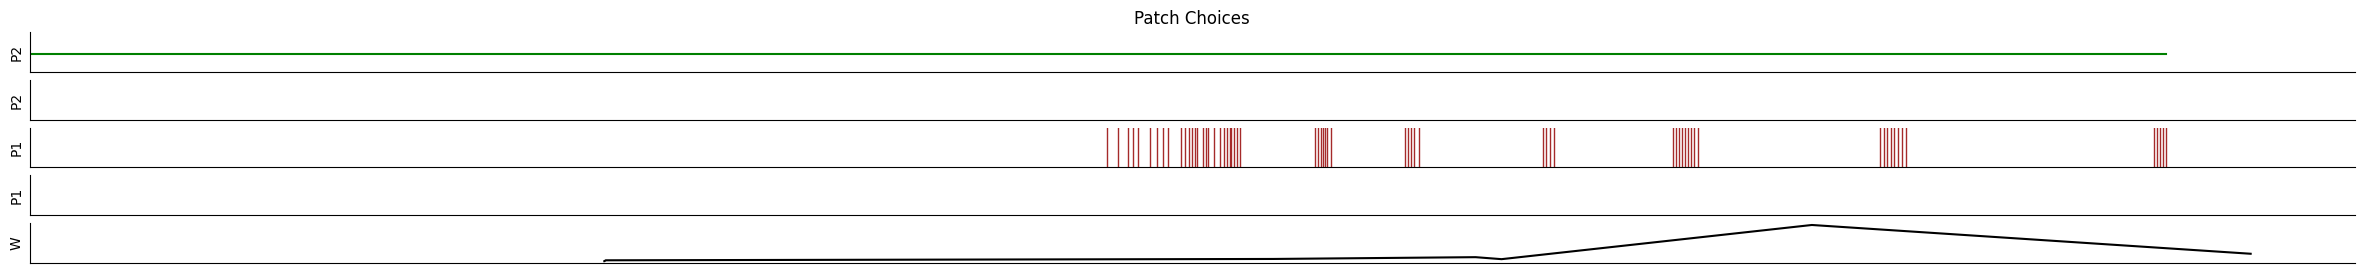

BAA-1101819
2022-07-19 10:37:08.422299862 2022-07-19 16:04:43.376220226


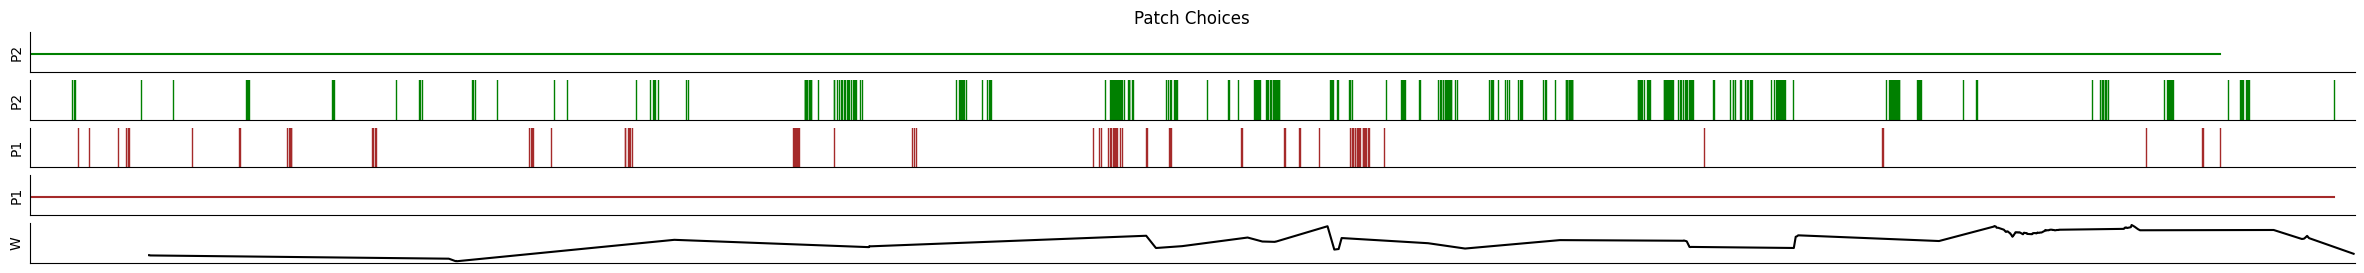

BAA-1101818
2022-07-19 13:04:16.233019829 2022-07-19 16:05:35.280479908


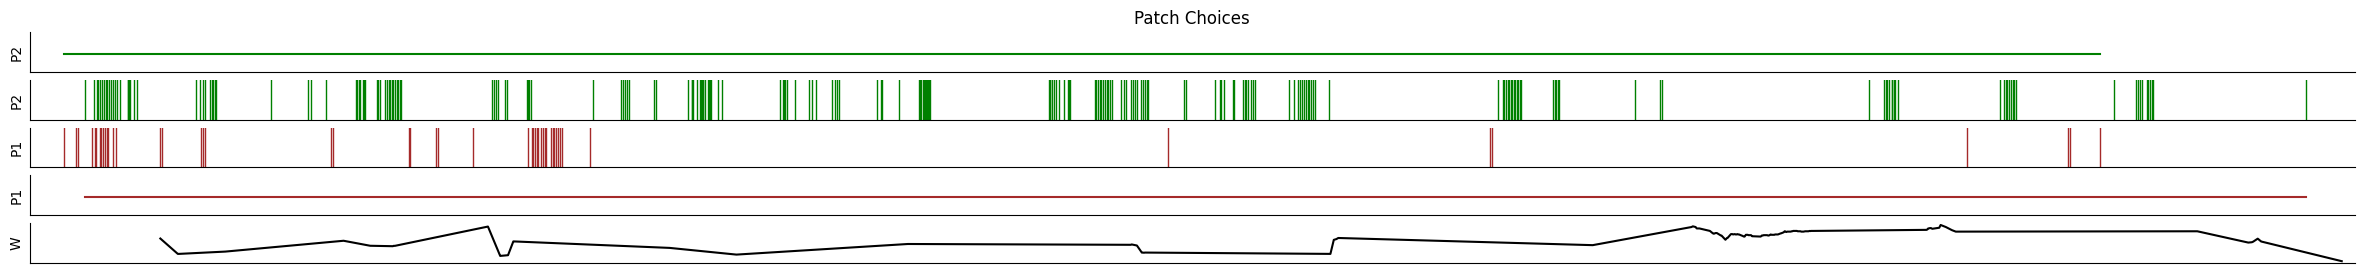

BAA-1101818
2022-08-15 10:25:01.651199818 2022-08-15 13:04:50.849309921


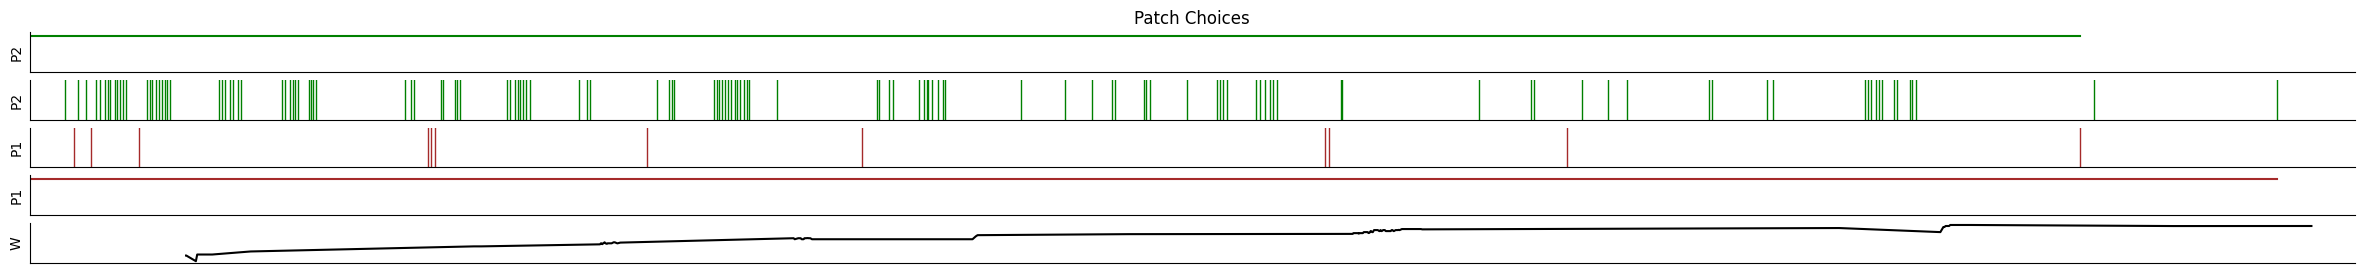

BAA-1101819
2022-08-15 13:11:23.791259766 2022-08-15 16:10:27.350080013


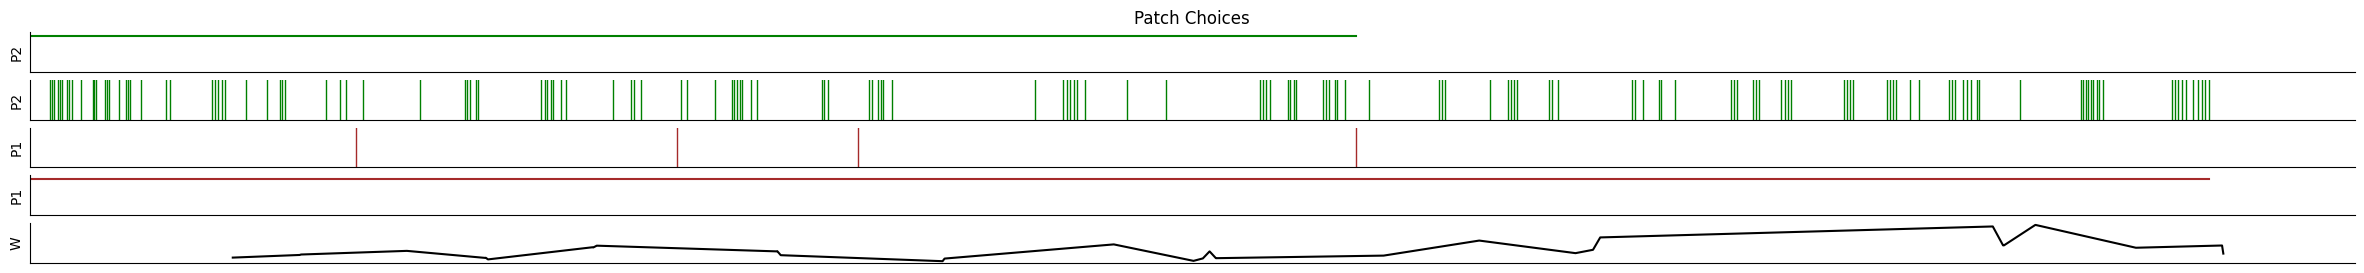

BAA-1101818
2022-08-16 09:25:53.963200092 2022-08-16 12:34:02.296770096


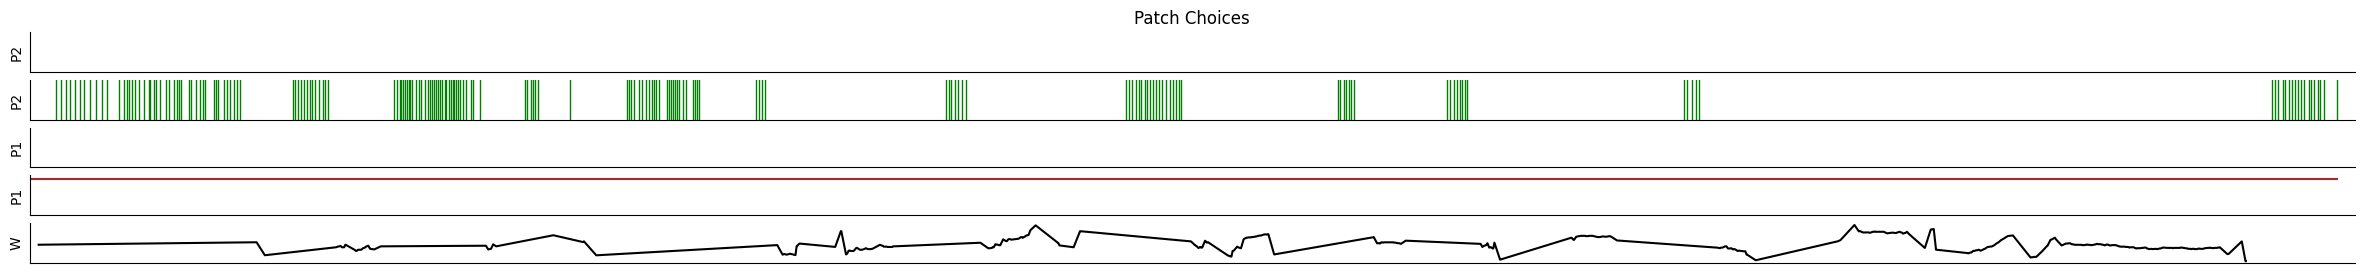

BAA-1101819
2022-08-16 12:38:11.445700169 2022-08-16 15:41:41.197569847


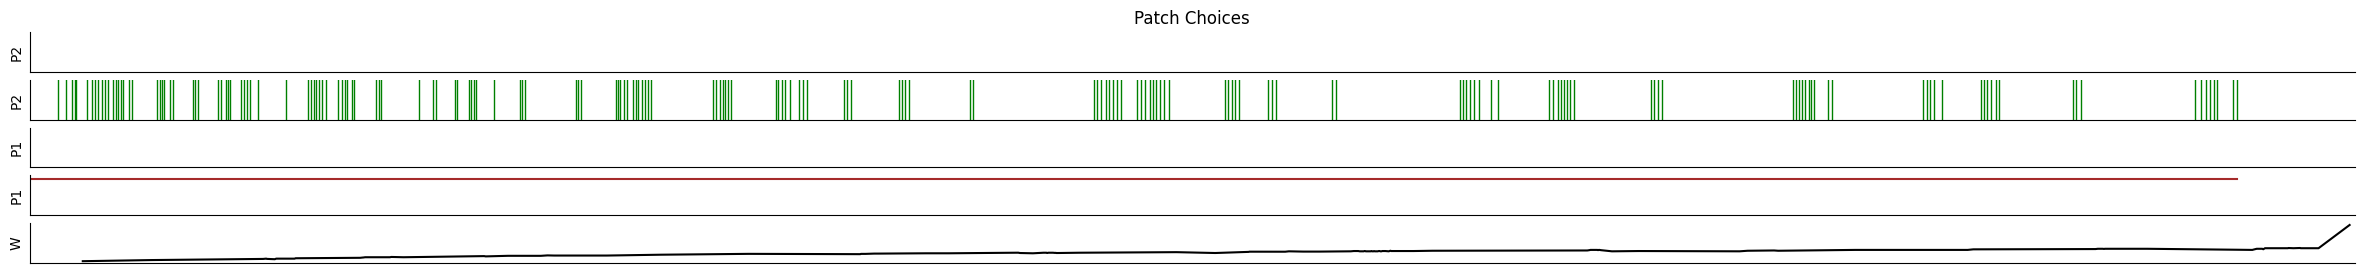

BAA-1102227
2022-08-24 12:57:30.558179855 2022-08-31 12:24:00.331900120


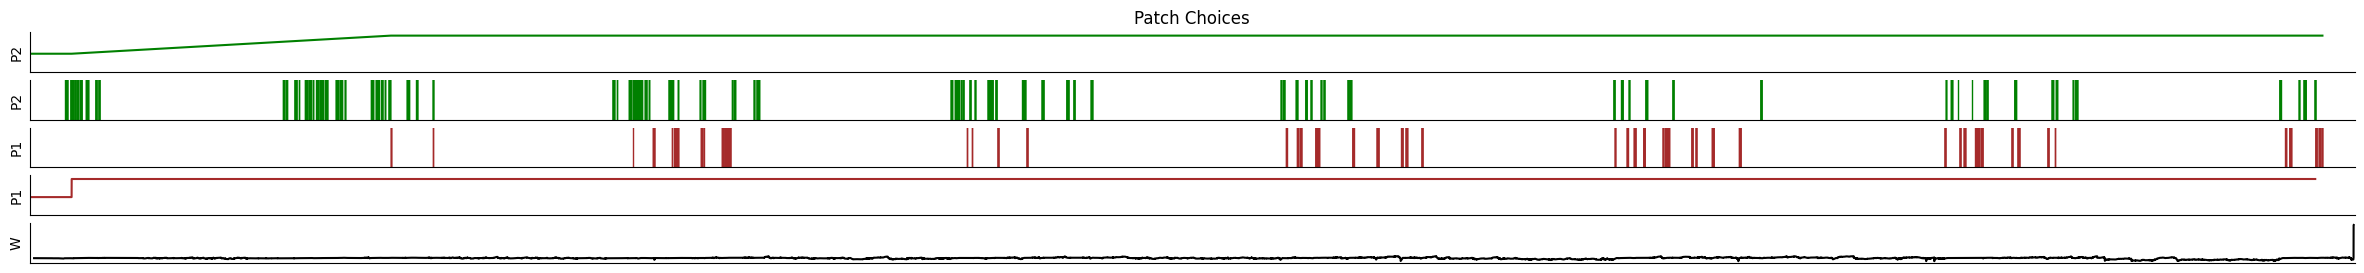

BAA-1102223
2022-09-26 10:37:39.908189774 2022-10-03 09:10:14.448420048


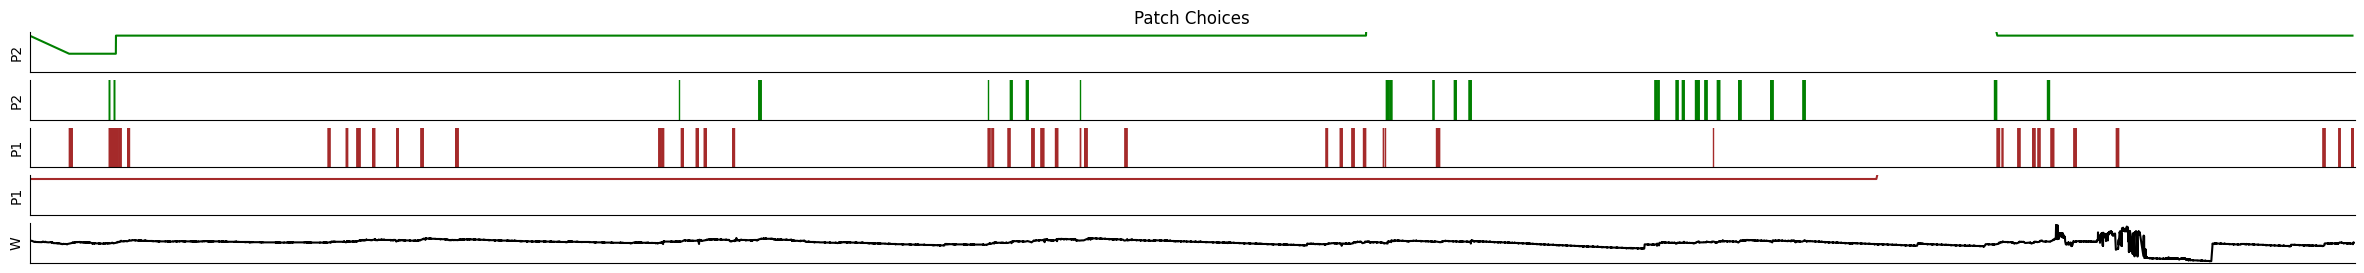

BAA-1102224
2022-10-03 11:04:29.183259964 2022-10-10 11:00:44.072539806


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:145: UserWarning: data index for Nest_204_* contains out-of-order timestamps!
  warnings.warn(f"data index for {reader.pattern} contains out-of-order timestamps!")


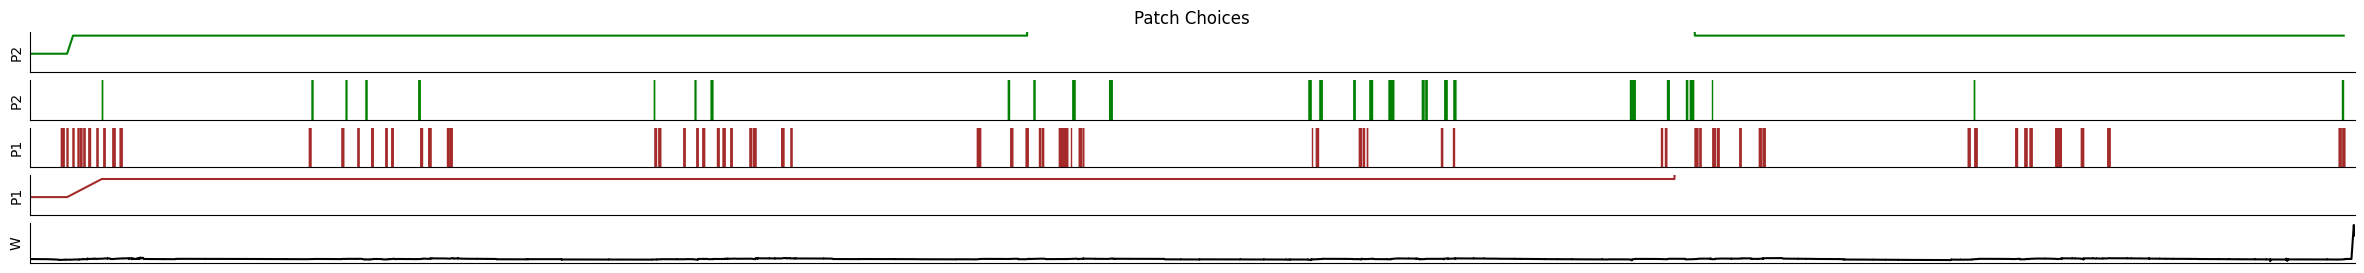

In [14]:
for i in range(len(sessions)):
    ID = sessions['id'][i]
    start, end = sessions['enter'][i], sessions['exit'][i] 
    print(ID)
    print(start, end)
    
    pstate1 = api.load(root, exp02.Patch1.DepletionState, start=start, end=end)
    pstate2 = api.load(root, exp02.Patch2.DepletionState, start=start, end=end)

    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
    #aeon.load(root, exp02.ExperimentMetadata.Messagelog, start = start, end = end)
    weight= api.load(root, exp02.Nest.WeightSubject, start=start, end=end)

    fig, axs = plt.subplots(5, 1, figsize=(30, 3), sharex=True)

    axs[0].plot(pstate2.index, pstate2['threshold'].to_numpy(), color = 'green')
    axs[0].set_xticks([]) 
    axs[0].set_yticks([]) 
    axs[0].set_facecolor('white') 
    axs[0].set_title('Patch Choices')
    axs[0].set_ylabel('P2')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_xlim(start, end)
    axs[0].set_ylim(0, 110)

    for pellet in pellets_patch1.itertuples():
        forage_time = pellet.Index
        axs[1].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
    axs[1].set_xticks([]) 
    axs[1].set_yticks([]) 
    axs[1].set_facecolor('white') 
    axs[1].set_ylabel('P2')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_xlim(start, end)

    for pellet in pellets_patch2.itertuples():
        forage_time = pellet.Index
        axs[2].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
    axs[2].set_yticks([])  
    axs[2].set_facecolor('white')  
    axs[2].set_ylabel('P1')
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].set_xlim(start, end)
    
    axs[3].plot(pstate1.index, pstate1['threshold'].to_numpy(), color = 'brown')
    axs[3].set_xticks([]) 
    axs[3].set_yticks([]) 
    axs[3].set_facecolor('white') 
    axs[3].set_ylabel('P1')
    axs[3].spines['top'].set_visible(False)
    axs[3].spines['right'].set_visible(False)
    axs[3].set_xlim(start, end)
    axs[3].set_ylim(0, 110)
    
    axs[4].plot(weight.index, weight['value'].to_numpy(), color = 'black')
    axs[4].set_xticks([]) 
    axs[4].set_yticks([]) 
    axs[4].set_facecolor('white') 
    axs[4].set_ylabel('W')
    axs[4].spines['top'].set_visible(False)
    axs[4].spines['right'].set_visible(False)
    axs[4].set_xlim(start, end)

    plt.show()
    
